In [55]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

from nltk.corpus import stopwords
from nltk.corpus import wordnet 
from nltk.corpus import stopwords
import nltk
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfFile, PdfPages
from ctypes.wintypes import SIZE
from astropy.timeseries import LombScargle
from matplotlib.backends.backend_pdf import PdfFile, PdfPages
import numpy as np
from astropy.timeseries import LombScargle
import matplotlib.transforms as transforms
from matplotlib.offsetbox import AnchoredText
from scipy.signal import argrelextrema
import time 

In [56]:
def calculate(gcs): #所以gcs要是string

    
    df = pd.read_csv(gcs) 

    df['Start_time'] = pd.to_numeric(df['Start_time'])
    #df['end_time'] = pd.to_numeric(df['end_time'])
    global all_sentences001
    all_sentences001 = []
    for t in range(0,480):
        sentences = []
        for index, rows in df.loc[(df["Start_time"]>=t) & (df["Start_time"]<=(t+10))].iterrows():
            sentences.append(rows["Words"])
        all_sentences001.append(" ".join(sentences))

    '''
    model = SentenceTransformer('all-MiniLM-L6-v2')
    global SBERT 
    SBERT= []

    def get_cosine_similarity(feature_vec_1, feature_vec_2):    
        return cosine_similarity(feature_vec_1.reshape(1, -1), feature_vec_2.reshape(1, -1))[0][0]
    # Two lists of sentences
    for i in range(0,len(all_sentences001)-1):
        #Compute embedding for both lists
        embeddings1 = model.encode(all_sentences001[i], convert_to_tensor=True)
        embeddings2 = model.encode(all_sentences001[i+1], convert_to_tensor=True)

        #Compute cosine-similarities
        cosine_scores = util.cos_sim(embeddings1, embeddings2)
        # convert from PyTorch tensor to numpy array
        SBERT.append(get_cosine_similarity(embeddings1, embeddings2))
    ######
    '''
    all_sentences001 = []
    stops = set(stopwords.words('english'))
    for t in range(0,480):
        sentences = []
        for index, rows in df.loc[(df["Start_time"]>=t) & (df["Start_time"]<=(t+10))].iterrows():
            if rows["Words"].lower() not in stops:
                sentences.append(rows["Words"].lower())
        all_sentences001.append(" ".join(sentences))
    
    #nltk.download('omw-1.4')
    #nltk.download('wordnet')
    #nltk.download('stopwords')
    global syn_counts
    syn_counts = []
    stops = set(stopwords.words('english'))
    global all_sentences_wu_sum
    all_sentences_wu_sum = []
    global all_sentences_wu_sum_divided
    all_sentences_wu_sum_divided = []
    global sen_depth
    sen_depth = []
    global average_depth
    average_depth = []
    for sentence_num in range(0,len(all_sentences001)): #現在第幾句
        the_sentence = str(all_sentences001[sentence_num]).split()
        #print(the_sentence)
        fast_depth = 0
        syn_counts = 0
        for words_num in range(0, (len(the_sentence))): #標定字
            if len(wordnet.synsets(the_sentence[words_num])) > 0 :
                syns1 = wordnet.synsets(the_sentence[words_num])
                syns1_num = len(syns1)#這個字有幾個synset
                syn_counts += syns1_num
                
                for synsnum in range(0,syns1_num):
                    depth = syns1[synsnum].min_depth()
                    fast_depth += depth
                
            else:
                continue
        sen_depth.append(fast_depth)
        average_depth.append(fast_depth/syn_counts)
           
    
    """ # for normalization
    wu_difference = np.array(wu_difference)
    SBERT = np.array(SBERT)
    #normalized_SBERT = preprocessing.normalize([SBERT])
    #normalized_wu_difference = preprocessing.normalize([wu_difference])


    min_max_scaler = preprocessing.MinMaxScaler()
    SBERT = np.reshape(SBERT,(479,1))
    wu_difference = np.reshape(wu_difference,(479,1))
    global normalized_SBERT
    global normalized_wu_difference
    normalized_SBERT  = min_max_scaler.fit_transform(SBERT)
    normalized_wu_difference  = min_max_scaler.fit_transform(wu_difference)
    """
    

In [57]:

num_of_extremum = 3 #設定想要找幾個極值

分段(大塊的)計算平均word depth

In [58]:
def average_word_depth(gcs,start,end): #這邊的start,end單位是no. of timeframe
    endtime = end
    df = pd.read_csv(gcs) 
    if end == "end":
        end = len(df) 
    else:
        end = end+10
    df['Start_time'] = pd.to_numeric(df['Start_time'])
    #df['end_time'] = pd.to_numeric(df['end_time'])
    
    words = []
    for index, rows in df.loc[(df["Start_time"]>=start) & (df["Start_time"]<=(end))].iterrows():
        words.append(rows["Words"])
    synset_depth_average = 0 #把一個字的synset的每個到root的可能路徑長度平均當作深度
    syn_counts = 0
    word_depth_list = []
    min_depth_list = []
    sum_of_synset_depths = 0
    for words_num in range(0, len(words)): #標定字
        if len(wordnet.synsets(words[words_num])) > 0 :
            syns1 = wordnet.synsets(words[words_num])
            syns1_num = len(syns1)#這個字有幾個synset
            syn_counts += syns1_num
            min_depth_synsets_sum = 0 #sum of 一個字的所有synset min_depth
            sum_of_words_synsets_depth = 0 #sum of 一個字的所有synset depth
            for synsnum in range(0,syns1_num):  #把每個synset的depth 都加上去
                
                #synset_depth_sum+=syns1[synsnum].min_depth()
                ### 用來算到lowest hyponyms的距離
                quick_synset_depth_average = 0
                quick_synset_depth_average = sum([len(path) for path in syns1[synsnum].hypernym_paths()])/len(syns1[synsnum].hypernym_paths()) #每個synset的平均深度
                if quick_synset_depth_average == 0:
                    print(syns1[synsnum].min_depth(), syns1[synsnum])
                sum_of_words_synsets_depth += quick_synset_depth_average #把一個字所有synset的depth加起來
                min_depth_synsets_sum += syns1[synsnum].min_depth() #把Min_depth全部加起來
                sum_of_synset_depths += quick_synset_depth_average
            min_depth_list += [min_depth_synsets_sum/syns1_num]
            word_depth_list += [sum_of_words_synsets_depth/syns1_num]
          
        else:
            continue
    average_depth = (sum(word_depth_list)/len(words))
    average_min_depth = (sum(min_depth_list)/len(words))
    average_synset_depth = (sum_of_words_synsets_depth/syn_counts)
    sd=np.std(word_depth_list, ddof=1)
    sdmin = np.std(min_depth_list, ddof=1)
    print("start:",start,"end:",endtime," average_depth = ",round(average_depth,4),",average_word_min_depth = ", round(average_min_depth,4),",average_synset_depth=",round(average_synset_depth,4),",depth_SD=", sd,",sdmin=",sdmin)

算word_depth SD

In [59]:
x = sum([i for i in range(10)])
print(x)

45


In [60]:
a = [1,2,3]
a.clear()
print(a)

[]


In [61]:
syns1 = wordnet.synsets("")
#print(syns1[0].min_depth())

In [62]:
for synsnum in range(0,len(syns1)):  #把每個synset的depth 都加上去
    #synset_depth_sum+=syns1[synsnum].min_depth()
    ### 用來算到lowest hyponyms的距離
    threshhold = syns1[synsnum].hyponyms() != []
    hyponyms_layer_count = 0
    hyponyms = []
    hyponyms += syns1[synsnum].hyponyms()
    
    while threshhold:
        threshhold = False
        hyponyms_layer_count += 1
        new_hyponyms = []
        #startt = time.time()
        for syns in hyponyms:
            if syns.hyponyms() != []:
                threshhold = True 
            for i in syns.hyponyms():
                #endd = time.time()
                #if (end-start)>10:
                    #   continue
                new_hyponyms += syns.hyponyms()
            
        hyponyms.clear()
        hyponyms = []
        hyponyms = new_hyponyms
        if threshhold == False:
            break
    

In [63]:
i=8
average_word_depth(f"data/Text/00{i}(done).csv",0,480)

start: 0 end: 480  average_depth =  3.0759 ,average_word_min_depth =  2.2779 ,average_synset_depth= 0.0008 ,depth_SD= 2.7229640225814924 ,sdmin= 2.641471839124403


In [64]:
i=10
average_word_depth(f"data/Text/0{i}(done).csv",0,150)
average_word_depth(f"data/Text/0{i}(done).csv",168,300)
average_word_depth(f"data/Text/0{i}(done).csv",300,480)
average_word_depth(f"data/Text/0{i}(done).csv",168,480)

start: 0 end: 150  average_depth =  3.0409 ,average_word_min_depth =  2.257 ,average_synset_depth= 0.0365 ,depth_SD= 2.5306433052106665 ,sdmin= 2.4640683713459635
start: 168 end: 300  average_depth =  2.8494 ,average_word_min_depth =  2.0786 ,average_synset_depth= 0.0052 ,depth_SD= 2.7281234519636177 ,sdmin= 2.6440779131915653
start: 300 end: 480  average_depth =  3.0798 ,average_word_min_depth =  2.297 ,average_synset_depth= 0.0351 ,depth_SD= 2.6249221296314453 ,sdmin= 2.544288898689927
start: 168 end: 480  average_depth =  3.0107 ,average_word_min_depth =  2.2322 ,average_synset_depth= 0.0192 ,depth_SD= 2.690928263194805 ,sdmin= 2.6089788395033278


In [65]:
i=18
average_word_depth(f"data/Text/0{i}(done).csv",0,150)
average_word_depth(f"data/Text/0{i}(done).csv",150,480)
average_word_depth(f"data/Text/0{i}(done).csv",250,"end")
average_word_depth(f"data/Text/0{i}(done).csv",300,480)

start: 0 end: 150  average_depth =  3.3187 ,average_word_min_depth =  2.53 ,average_synset_depth= 0.0004 ,depth_SD= 2.845108174767167 ,sdmin= 2.7651242328563326
start: 150 end: 480  average_depth =  3.2413 ,average_word_min_depth =  2.3996 ,average_synset_depth= 0.0005 ,depth_SD= 2.921129722303298 ,sdmin= 2.808818395144065
start: 250 end: end  average_depth =  3.1463 ,average_word_min_depth =  2.3115 ,average_synset_depth= 0.0007 ,depth_SD= 2.888363978948633 ,sdmin= 2.7639311062684166
start: 300 end: 480  average_depth =  2.9631 ,average_word_min_depth =  2.1454 ,average_synset_depth= 0.001 ,depth_SD= 2.790650758288144 ,sdmin= 2.656204593524151


In [66]:
i=11
average_word_depth(f"data/Text/0{i}(done).csv",0,300)
average_word_depth(f"data/Text/0{i}(done).csv",300,480)
average_word_depth(f"data/Text/0{i}(done).csv",250,"end")
average_word_depth(f"data/Text/0{i}(done).csv",300,480)

start: 0 end: 300  average_depth =  3.2487 ,average_word_min_depth =  2.4651 ,average_synset_depth= 0.0272 ,depth_SD= 2.729041166024455 ,sdmin= 2.645097322427652
start: 300 end: 480  average_depth =  3.1036 ,average_word_min_depth =  2.3303 ,average_synset_depth= 0.0046 ,depth_SD= 2.6134089955769197 ,sdmin= 2.5602382076994648
start: 250 end: end  average_depth =  3.1822 ,average_word_min_depth =  2.4176 ,average_synset_depth= 0.0035 ,depth_SD= 2.6010588317222045 ,sdmin= 2.544282359922763
start: 300 end: 480  average_depth =  3.1036 ,average_word_min_depth =  2.3303 ,average_synset_depth= 0.0046 ,depth_SD= 2.6134089955769197 ,sdmin= 2.5602382076994648


In [67]:
i=13
average_word_depth(f"data/Text/0{i}(done).csv",0,200)
average_word_depth(f"data/Text/0{i}(done).csv",200,480)
average_word_depth(f"data/Text/0{i}(done).csv",250,"end")
average_word_depth(f"data/Text/0{i}(done).csv",300,480)

start: 0 end: 200  average_depth =  2.9958 ,average_word_min_depth =  2.2514 ,average_synset_depth= 0.0619 ,depth_SD= 2.7821859755355813 ,sdmin= 2.6796399978798724
start: 200 end: 480  average_depth =  2.646 ,average_word_min_depth =  1.9553 ,average_synset_depth= 0.0238 ,depth_SD= 2.6769901782185137 ,sdmin= 2.61743239034102
start: 250 end: end  average_depth =  2.5918 ,average_word_min_depth =  1.9107 ,average_synset_depth= 0.0293 ,depth_SD= 2.654085198594627 ,sdmin= 2.6046387757681404
start: 300 end: 480  average_depth =  2.5181 ,average_word_min_depth =  1.8596 ,average_synset_depth= 0.0373 ,depth_SD= 2.5535140743650198 ,sdmin= 2.5208573465819746


畫圖的部分

In [68]:
def draw(gcs,num):
    df = pd.read_csv(gcs)

    x = [i for i in range(len(average_depth))]
    global pdfFile
     #這邊是創建pdf檔案
    if num <10:
        pdfFile = PdfPages(f"data/word_depth/00{num}(word_depth).pdf")
    else: 
        pdfFile = PdfPages(f"data/word_depth/0{num}(word_depth).pdf")
    
    fig = plt.figure(figsize=(20,6))
    #plt.rcParams["figure.figsize"] = (20, 6)
    plt.plot(average_depth,label = "wu_pulmer")
    plt.xlabel("Timeframe(no.)")
    plt.ylabel("average word_depth")
    plt.title(f"subject:{num}     average_word_depth")
    plt.xlim(0,500)
    plt.grid()
    plt.legend()
    plt.show
    pdfFile.savefig(fig)
    


    frequency, power = LombScargle(x,average_depth).autopower(minimum_frequency=0.01,maximum_frequency=0.1)
    fig = plt.figure(figsize = (20,6))
    #fig, ax=plt.subplots(figsize = (20,6))
    plt.title(f"subject:{num}     average_depth ")
    plt.grid()
    plt.xlabel("frequency")
    plt.plot(frequency, power)   
    power_new = np.sort(power)
    extremum = np.sort(power[argrelextrema(power,np.greater)])
    pmaxf = np.array([])
    for i in range(1, (num_of_extremum+1)):
        pmaxf = np.append(pmaxf,frequency[np.where(power == extremum[-i])])
        #plt.axhline(y=extremum[-i], linestyle = "dashed", xmin=0.01, xmax=20,color = "red") #這條是y水平線，想要可以加
        plt.axvline(x = pmaxf[-1], linestyle = "dashed", ymin=0, ymax = 25 ,color = "red") #因為pmaxf一直在新增，所以輪到那圈時的pmax[-1]就會是那圈新增的第i大的power的f
    #trans = transforms.blended_transform_factory( ax.get_yticklabels()[0].get_transform(), ax.transData)
    #plt.text(0,23, "{:.0f}".format(max(power)), color="red", transform=trans, ha="right", va="center")
    #plt.scatter(argrelextrema(power,np.greater), power[argrelextrema(power,np.greater)],c='red') #找極值用的
    plt.annotate(f'f={pmaxf[:]}\npmax={extremum[:-num_of_extremum-1:-1]}', xy=(0.4, 0.7), xycoords='axes fraction') 
    pdfFile.savefig(fig)


    pdfFile.close()

參數表:<br>
all_sentences001: 所有的句子整合(沒有刪掉stop words)<br>
SBERT: 具有全部SBERT similarity的list<br>
all_sentences_wu_sum: 每句話的wu-pulmer similarity算出來的平均的list<br>
wu_difference: 兩句兩句減掉wu similarity的list<br>
normalized_SBERT: 就是表準化過後的SBERT list<br>
normalized_wu_difference: 標準化過後的wu_pulmer difference<br>
這邊注意wu-pulmer的different based應該不能這樣算

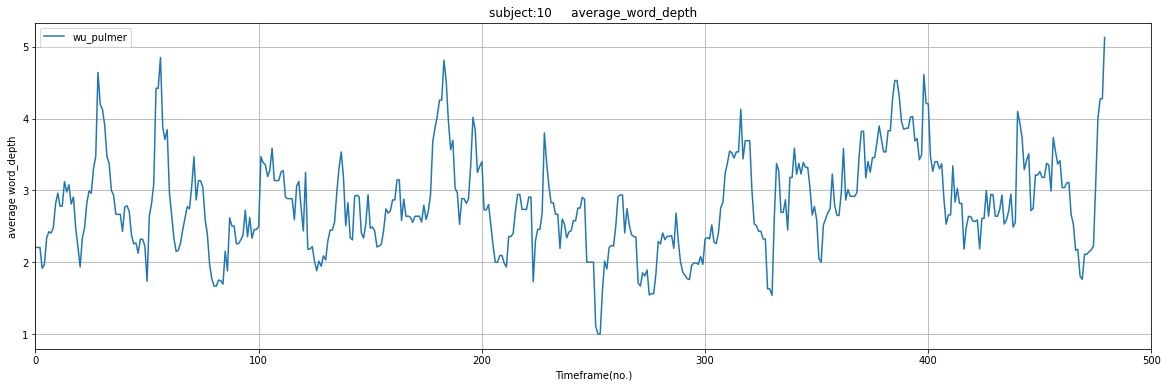

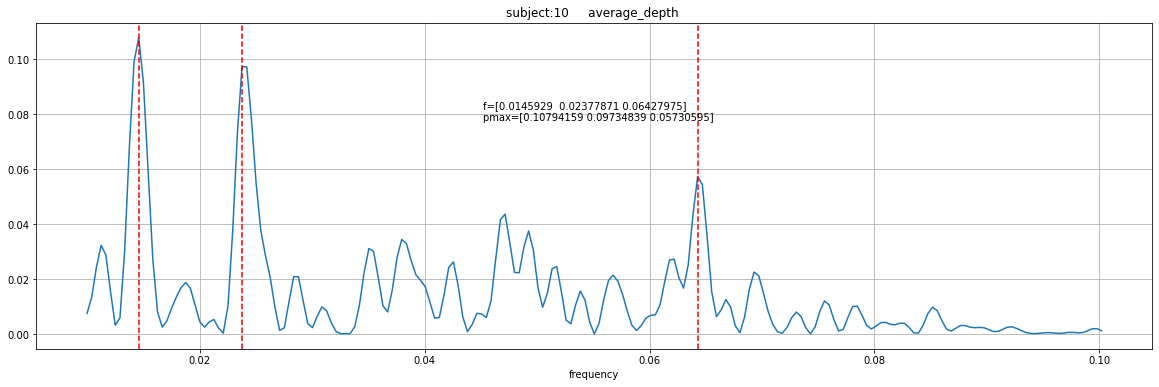

In [69]:

i = 10
calculate(f"data/Text/0{i}(done).csv")
draw(f"data/Text/0{i}(done).csv",i)
#results_csv = pd.DataFrame(list(zip(SBERT,all_sentences_wu_sum,all_sentences_wu_sum_divided,pair_counts)), columns = ['SBERT',"Wu-Pulmer","Wu-Pulmer_divided","pair_counts"])
#results_csv.to_csv(f'data/Text/00{i}(results).csv')



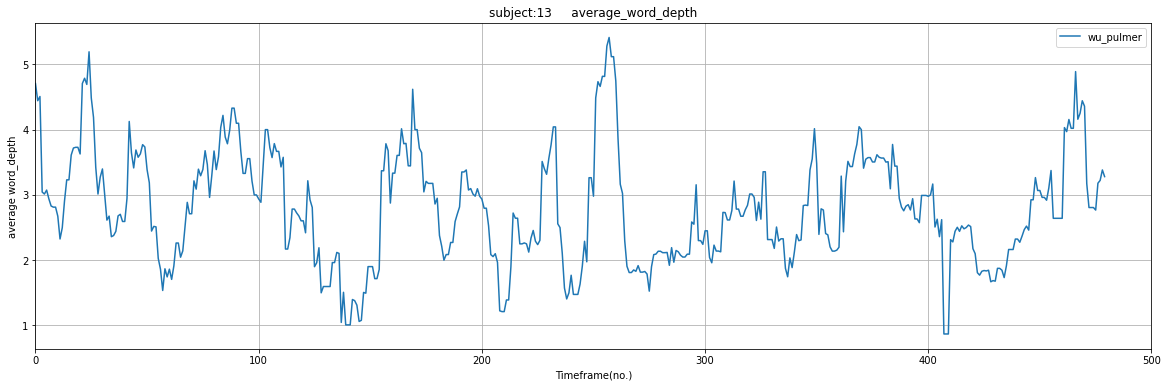

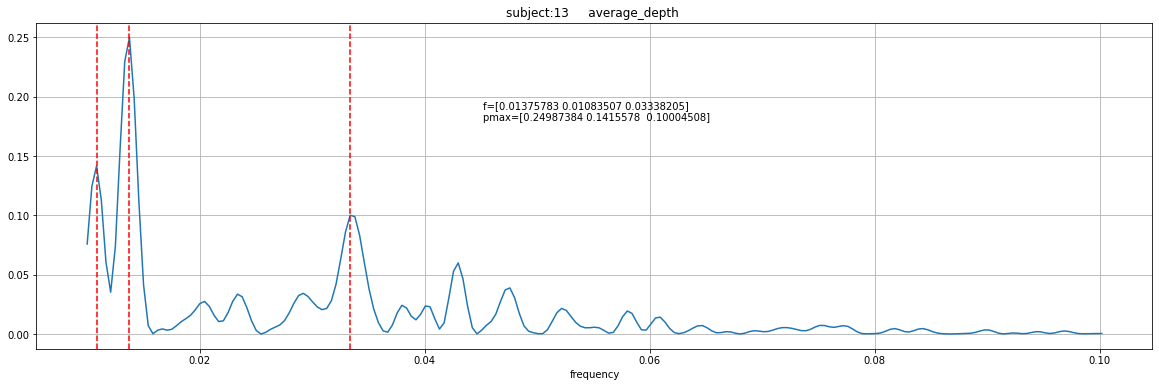

In [70]:

i = 13
calculate(f"data/Text/0{i}(done).csv")
draw(f"data/Text/0{i}(done).csv",i)

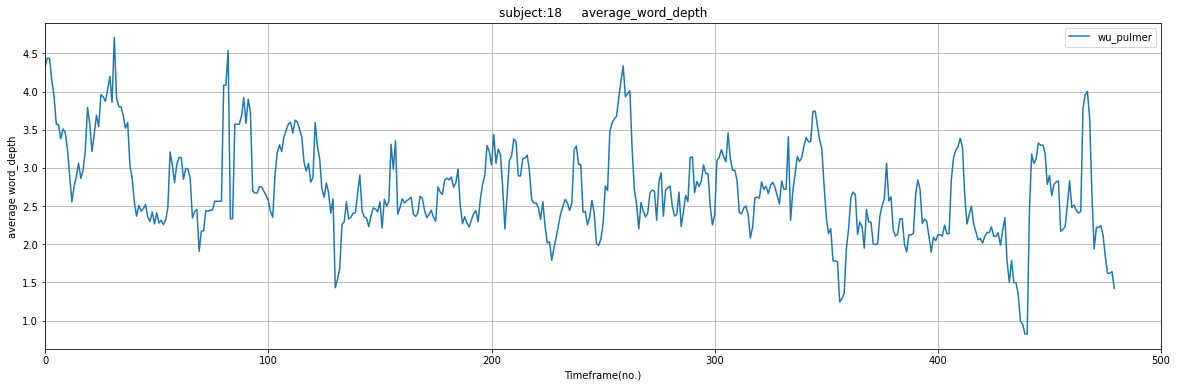

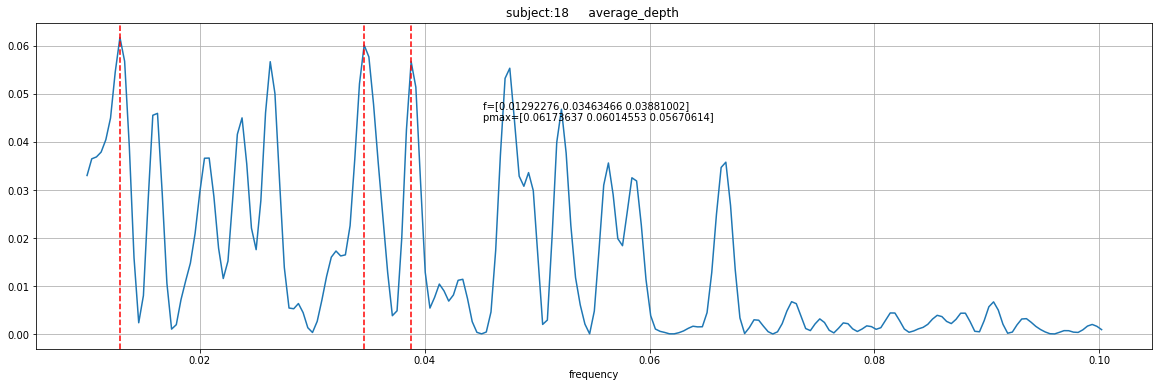

In [71]:

i = 18
calculate(f"data/Text/0{i}(done).csv")
draw(f"data/Text/0{i}(done).csv",i)

In [72]:
for i in range(0,0):
    if i<10:
        try:
            calculate(f"data/Text/00{i}(done).csv")
            results_csv = pd.DataFrame(list(zip(SBERT,all_sentences_wu_sum,all_sentences_wu_sum_divided,pair_counts)), columns = ['SBERT',"Wu-Pulmer","Wu-Pulmer_divided","pair_counts"])
            results_csv.to_csv(f'data/Text/00{i}(results).csv')
        except:
            print("error:", i)
            continue
    else:
        try:
            calculate(f"data/Text/0{i}(done).csv")
            results_csv = pd.DataFrame(list(zip(SBERT,all_sentences_wu_sum,all_sentences_wu_sum_divided,pair_counts)), columns = ['SBERT',"Wu-Pulmer","Wu-Pulmer_divided","pair_counts"])
            results_csv.to_csv(f'data/Text/0{i}(results).csv')
        except:
            print("error:", i)
            continue